In [ ]:
!nvidia-smi

Tue Apr 26 19:47:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cp "./drive/MyDrive/zerowaste-f-final.zip" ./
!unzip "./zerowaste-f-final.zip"

Streaming output truncated to the last 5000 lines.
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005690.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005700.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005710.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005720.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005730.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005740.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005750.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005760.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005770.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005780.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005790.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005800.PNG  
  inflating: splits_final_deblurred/train/sem_seg/05_frame_005810.PNG  
  inflating: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ----- #
# Install detectron2
# ----- #
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!gcc --version
# opencv is pre-installed on colab
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 23 kB/s 
     |████████████████████████████████| 6.6 MB 59.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 16.1 MB/s 
  Created wheel f

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os
import numpy as np
import cv2
import json
import random
from PIL import Image
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

In [ ]:
%pwd

'/content'

In [ ]:
import json
 
def json2dict(path):
    with open(path) as f:
        return json.load(f)
        
labels_test = json2dict("./splits_final_deblurred/test/labels.json")

img_all = labels_test["images"]
anno_raw = labels_test["annotations"]
anno_all = [list() for idx in range(3002)]

for idx in range(len(anno_raw)):
    tmp = anno_raw[idx]
    idx_img = tmp["image_id"]
    anno_all[idx_img].append(tmp)

In [ ]:
img_all[0]

{'coco_url': None,
 'file_name': '05_frame_000001.PNG',
 'height': 1080,
 'id': 0,
 'license': None,
 'width': 1920}

In [ ]:
def get_zerowaste_dicts():
    dataset_dicts = []
    for idx0 in range(len(img_all)):
        record = dict()
        tmp = img_all[idx0]
        record["file_name"] = os.path.join("./splits_final_deblurred/test/data", tmp["file_name"])
        record["image_id"] = tmp["id"]
        record["width"] = tmp["width"]
        record["height"] = tmp["height"]
        
        tmp_tmp = anno_all[idx0]
        objs = list()
        for item in tmp_tmp:
            obj = dict()
            obj["bbox"] = item["bbox"]
            obj["bbox_mode"] = BoxMode.XYWH_ABS
            obj["segmentation"] = item["segmentation"]
            obj["category_id"] = item["category_id"] - 1
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.clear()
DatasetCatalog.register("zerowaste_test", get_zerowaste_dicts)
MetadataCatalog.get("zerowaste_test").set(thing_classes=["class0", "class1", "class2", "class3"])
zerowaste_metadata = MetadataCatalog.get("zerowaste_test")

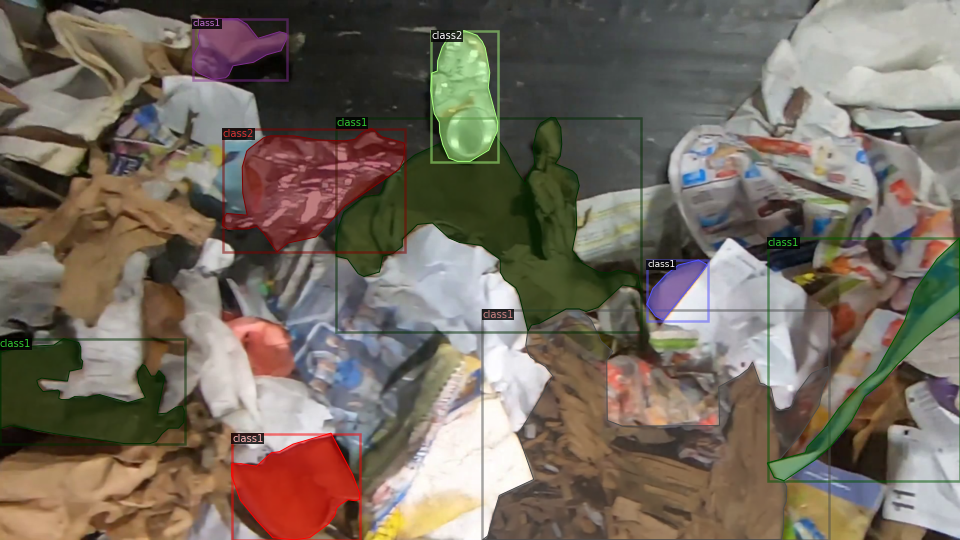

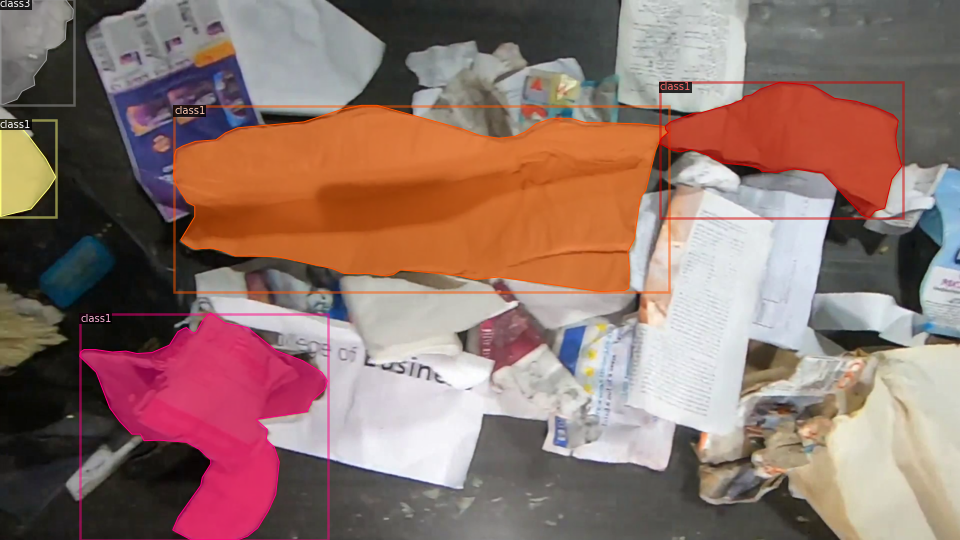

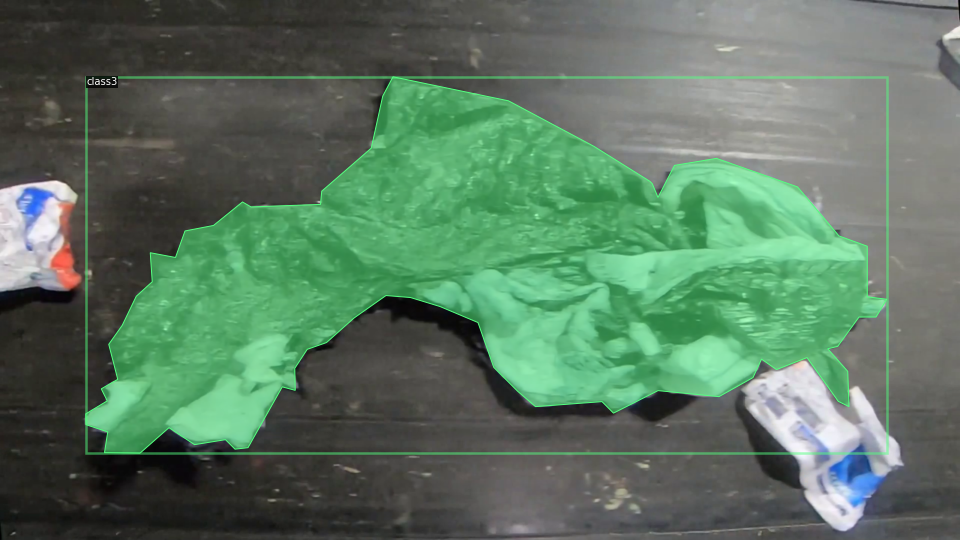

In [ ]:
dataset_dicts = get_zerowaste_dicts()
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=zerowaste_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("zerowaste_test",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.01  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # we have 4 classes

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
cfg.DATASETS.TEST = ("zerowaste_train", )
predictor = DefaultPredictor(cfg)

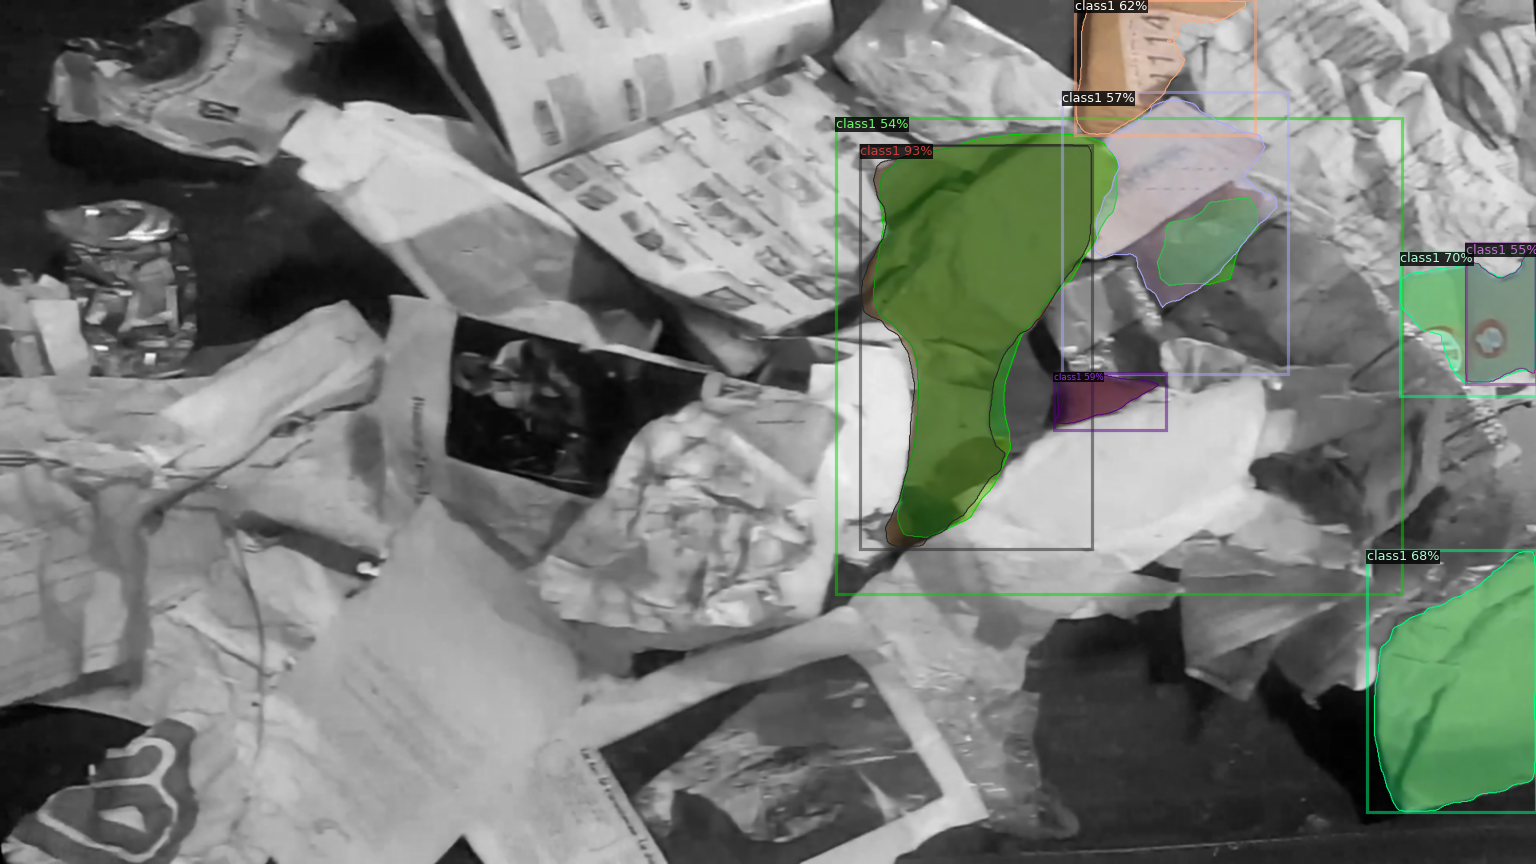

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_zerowaste_dicts()
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                    metadata=zerowaste_metadata, 
                    scale=0.8, 
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("zerowaste_train", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "zerowaste_train")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [04/26 20:07:33 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'zerowaste_train'. Trying to convert it to COCO format ...
[04/26 20:07:33 d2.data.datasets.coco]: Converting annotations of dataset 'zerowaste_train' to COCO format ...)
[04/26 20:07:34 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/26 20:07:35 d2.data.datasets.coco]: Conversion finished, #images: 3002, #annotations: 18002
[04/26 20:07:35 d2.data.datasets.coco]: Caching COCO format annotations at './output/zerowaste_train_coco_format.json' ...
[04/26 20:07:37 d2.data.common]: Serializing 3002 elements to byte tensors and concatenating them all ...
[04/26 20:07:37 d2.data.common]: Serialized dataset takes 9.25 MiB
[04/26 20:07:37 d2.evaluation.evaluator]: Start inference on 3002 images
[04/26 20:07:45 d2.evaluation.evaluator]: Inference done 11/3002. 0.1236 s / img. ETA=0:32:55
[04/26 20:07:50 d2.evaluation.evaluator]: Inference done 20/3002. 0.1220 s / img. ETA

OrderedDict([('bbox',
              {'AP': 19.182715037106075,
               'AP-class0': 11.51020919816653,
               'AP-class1': 22.005901688706196,
               'AP-class2': 22.869102770682165,
               'AP-class3': 20.345646490869417,
               'AP50': 33.64400359852643,
               'AP75': 19.803536118305853,
               'APl': 21.454820672745388,
               'APm': 8.812665263356813,
               'APs': 3.7064651184604016}),
             ('segm',
              {'AP': 21.49478121716705,
               'AP-class0': 13.39270267727165,
               'AP-class1': 24.738300056414978,
               'AP-class2': 25.041856096725006,
               'AP-class3': 22.806266038256556,
               'AP50': 33.845008055623616,
               'AP75': 23.621038480523858,
               'APl': 25.348663966357364,
               'APm': 6.6575157983811515,
               'APs': 0.9915542014315768})])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("zerowaste_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "zerowaste_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [04/26 21:08:36 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'zerowaste_test'. Trying to convert it to COCO format ...
[04/26 21:08:36 d2.data.datasets.coco]: Converting annotations of dataset 'zerowaste_test' to COCO format ...)
[04/26 21:08:36 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/26 21:08:37 d2.data.datasets.coco]: Conversion finished, #images: 929, #annotations: 5077
[04/26 21:08:37 d2.data.datasets.coco]: Caching COCO format annotations at './output/zerowaste_test_coco_format.json' ...
[04/26 21:08:37 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   class0   | 315          |   class1   | 3449         |   class2   | 63           |
|   class3   | 1250         |            |              |            |              |
|   

OrderedDict([('bbox',
              {'AP': 13.251330069375216,
               'AP-class0': 7.082437750951051,
               'AP-class1': 23.07912312775098,
               'AP-class2': 7.187214839141469,
               'AP-class3': 15.656544559657362,
               'AP50': 25.224437650364894,
               'AP75': 12.779321946156477,
               'APl': 14.030715779523058,
               'APm': 10.014288137812759,
               'APs': 2.393042374086538}),
             ('segm',
              {'AP': 15.124318531268127,
               'AP-class0': 8.420185866249035,
               'AP-class1': 26.133370244394925,
               'AP-class2': 8.516984077464954,
               'AP-class3': 17.42673393696359,
               'AP50': 25.666611675717405,
               'AP75': 15.41607737938126,
               'APl': 17.096635253634275,
               'APm': 6.986624614219735,
               'APs': 0.44083688127629594})])

In [ ]:
from shapely.geometry import Polygon
def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou